In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

import string
import math

print(tf.__version__)
np.set_printoptions(precision=3, suppress=True)

2.10.0


Obtenir les données

In [2]:
MAX_SIZE = 783
NUM_WORDS = 1000
CHUNKSIZE = 100000
NUM_EPOCHS = 10
EMBEDDING_DIM = 16
EPOCHS = 10
BATCH_SIZE = 512
LOG_DIR = "src/tensorboard"
OOV = 0
SARCASM_TRAINING_SIZE = 20000

def tokenizer_func(data_rating, data_review):
    tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token=OOV)
    tokenizer.fit_on_texts(data_review)

    word_index = tokenizer.word_index

    train_labels = data_rating.iloc[math.floor(int(len(data_rating) / 8)):]
    train_examples = data_review.iloc[math.floor(int(len(data_review) / 8)):]
    test_examples = data_review.iloc[:math.floor(int(len(data_review) / 8))]
    test_labels = data_rating.iloc[:math.floor(int(len(data_rating) / 8))]

    sequences_train = tokenizer.texts_to_sequences(train_examples)
    sequences_test = tokenizer.texts_to_sequences(test_examples)

    padded_train = pad_sequences(sequences_train, padding='post', truncating='post', maxlen=MAX_SIZE)
    padded_test = pad_sequences(sequences_test, padding='post', truncating='post', maxlen=MAX_SIZE)

    return np.array(padded_train), np.array(padded_test), np.array(train_labels), np.array(test_labels)

In [3]:
url_train_with_reading_time_NaN = 'src/data/initial/goodreads_train_with_reading_time_NaN.csv'
url_train_with_reading_time = 'src/data/initial/goodreads_train_with_reading_time.csv'
url_train_not_reading_time = 'src/data/initial/goodreads_train_not_reading_time.csv'

raw_dataset = pd.read_csv(url_train_with_reading_time_NaN, 
                          na_values='?', sep=',')

# Solution 1 / ne marche pas
# raw_dataset = raw_dataset.replace('a','1', regex=True)
# raw_dataset = raw_dataset.replace('b','2', regex=True)
# raw_dataset = raw_dataset.replace('c','3', regex=True)
# raw_dataset = raw_dataset.replace('d','4', regex=True)
# raw_dataset = raw_dataset.replace('e','5', regex=True)
# raw_dataset = raw_dataset.replace('f','6', regex=True)
# raw_dataset = raw_dataset.replace('g','7', regex=True)
# raw_dataset = raw_dataset.replace('h','8', regex=True)
# raw_dataset = raw_dataset.replace('i','9', regex=True)
# raw_dataset = raw_dataset.replace('j','10', regex=True)
# raw_dataset = raw_dataset.replace('k','11', regex=True)
# raw_dataset = raw_dataset.replace('l','12', regex=True)
# raw_dataset = raw_dataset.replace('m','13', regex=True)
# raw_dataset = raw_dataset.replace('n','14', regex=True)
# raw_dataset = raw_dataset.replace('o','15', regex=True)
# raw_dataset = raw_dataset.replace('p','16', regex=True)
# raw_dataset = raw_dataset.replace('q','17', regex=True)
# raw_dataset = raw_dataset.replace('r','18', regex=True)
# raw_dataset = raw_dataset.replace('s','19', regex=True)
# raw_dataset = raw_dataset.replace('t','20', regex=True)
# raw_dataset = raw_dataset.replace('u','21', regex=True)
# raw_dataset = raw_dataset.replace('v','22', regex=True)
# raw_dataset = raw_dataset.replace('w','23', regex=True)
# raw_dataset = raw_dataset.replace('x','24', regex=True)
# raw_dataset = raw_dataset.replace('y','25', regex=True)
# raw_dataset = raw_dataset.replace('z','26', regex=True)

# Solution 2 / ne marche pas
# for char in list(string.ascii_lowercase):
#     print(char, type(ord(char)))
#     raw_dataset = raw_dataset.replace(char, ord(char), regex=True)
#     print(raw_dataset.tail())
# raw_dataset = raw_dataset.astype(float)

# Solution 3 / marche mais pas sue tout le data set
# df_mask=raw_dataset['rating']==2
# filtered_df = raw_dataset[df_mask]

# raw_dataset2 = pd.get_dummies(filtered_df['review_id'])
# print(raw_dataset2.tail())

# Solution 4 / marche mais pas les id les book
raw_dataset = raw_dataset.drop(['review_id', 'review_text'], axis=1)

# df_test = tokenizer_func(raw_dataset['rating'], raw_dataset["review_text"])
# print(df_test)

dataset = raw_dataset.copy()
print(dataset.tail())

        rating  reading_time  localisation
899995       5           4.0          -700
899996       5           NaN          -700
899997       0           NaN          -700
899998       4           4.0          -700
899999       5           1.0          -700


Nettoyer les données

In [4]:
# suppretion des valeurs vides
dataset = dataset.dropna()

print(dataset.tail())

        rating  reading_time  localisation
899993       4           4.0          -700
899994       5           2.0          -700
899995       5           4.0          -700
899998       4           4.0          -700
899999       5           1.0          -700


Diviser les données en train et test

In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Séparer la valeur rechercher

In [6]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('rating')
test_labels = test_features.pop('rating')

Normalisation des données

In [7]:
normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(np.array(train_features)) # .values.astype(np.float32)

normalizer.mean.numpy()

# first = np.array(train_features[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

array([[  11.507, -732.904]], dtype=float32)

Régression linéaire

In [8]:
# affichage entrainement 
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [9]:
# Modele
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 8
Trainable params: 3
Non-trainable params: 5
_________________________________________________________________


C:\Users\tomcareghi\.conda\envs\DeepLearning\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


12310/12310 [==============================] - 73s 6ms/step - loss: 0.8318 - val_loss: 0.8233


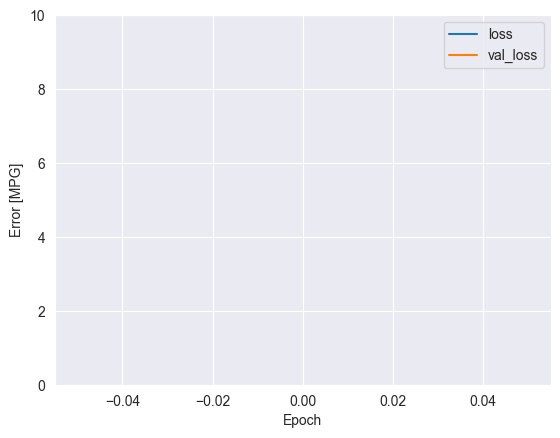

In [11]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = linear_model.fit(
    train_features,
    train_labels,
    epochs=1,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)
plot_loss(history)

In [12]:
test_results = {}
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

MLP

In [34]:
# Model
mlp_model = keras.Sequential([
  normalizer,
  layers.Dense(64, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1)
])

mlp_model.compile(loss='mean_absolute_error',
            optimizer=tf.keras.optimizers.Adam(0.001))
mlp_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense_7 (Dense)             (None, 64)                192       
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,422
Trainable params: 4,417
Non-trainable params: 5
_________________________________________________________________


C:\Users\tomcareghi\.conda\envs\DeepLearning\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


12310/12310 [==============================] - 73s 6ms/step - loss: 0.8330 - val_loss: 0.8175


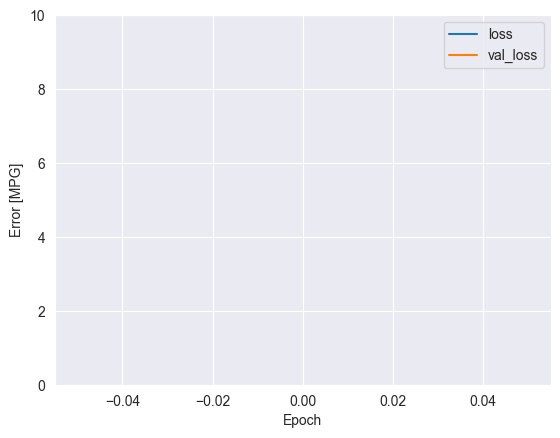

In [35]:
history = mlp_model.fit(
    train_features, #.values.astype(np.float32)
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=1)
plot_loss(history)

In [36]:
test_results['mlp_model'] = mlp_model.evaluate(test_features, test_labels, verbose=0)

In [37]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

Mean absolute error [MPG]
linear_model                   0.821948
mlp_model                      0.816430

Prédiction

3847/3847 [==============================] - 8s 2ms/step


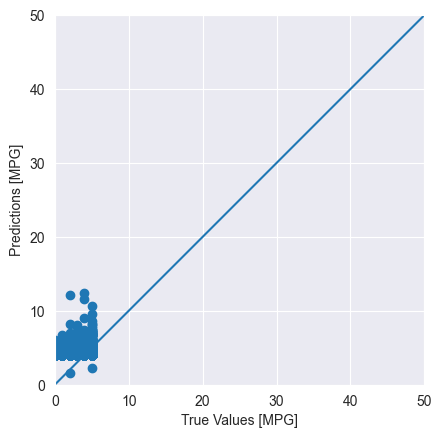

In [17]:
test_predictions_linear = linear_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions_linear)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

3847/3847 [==============================] - 8s 2ms/step


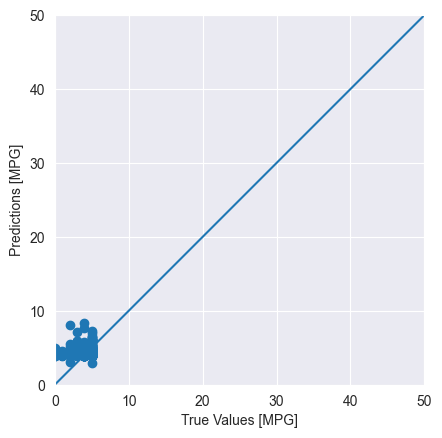

In [38]:
test_predictions_mlp = mlp_model.predict(test_features).flatten()
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions_mlp)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [39]:
print(len(test_predictions_mlp))
print(len(test_features))

123100
123100


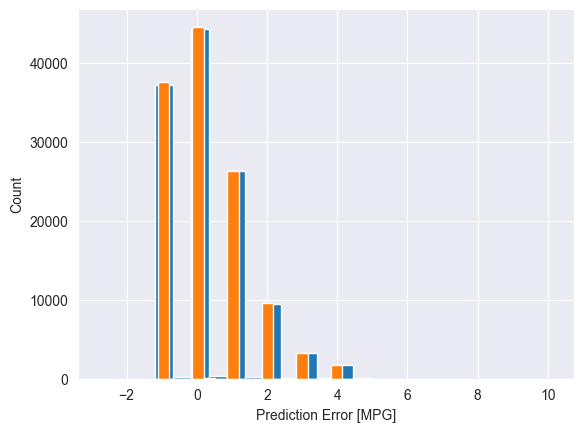

In [40]:
# distribution des erreurs

error_linear = test_predictions_linear - test_labels
plt.hist(error_linear, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

error_mlp = test_predictions_mlp - test_labels
plt.hist(error_mlp, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [41]:
# Save
# linear_model.save('linear_model')
mlp_model.save('mlp_model')

INFO:tensorflow:Assets written to: mlp_model\assets


In [48]:
# utiliser

url_test_with_reading_time_NaN = 'src/data/initial/goodreads_test_with_reading_time_NaN.csv'
url_test_with_reading_time = 'src/data/initial/goodreads_test_with_reading_time.csv'
url_test_not_reading_time = 'src/data/initial/goodreads_test_not_reading_time.csv'

raw_dataset_test = pd.read_csv(url_test_with_reading_time_NaN, 
                          na_values='?', sep=',')
dataset_test2 = raw_dataset_test.copy()
raw_dataset_test = raw_dataset_test.drop(['review_id', "review_text"], axis=1)
dataset_test = raw_dataset_test.copy()

# dataset_test = dataset_test.dropna()

reloaded = tf.keras.models.load_model('mlp_model')

test_predictions = reloaded.predict(dataset_test).flatten()
# print(test_predictions)

# test_results['reloaded'] = reloaded.evaluate(
#     test_features_test, test_labels_test, verbose=0)

14939/14939 [==============================] - 34s 2ms/step


In [26]:
for i in test_predictions:
    if not math.isnan(i[0]):
        print(i[0])
    else:
        print('nn')

3.9905338
3.956389
4.0015707
4.0010924
nn
nn
4.0014744
nn
nn
nn
nn
nn
4.0006146
3.9897978
nn
nn
nn
nn
nn
nn
nn
nn
nn
nn
4.0014744
3.986856
4.000806
4.001379
4.001379
nn
nn
4.0012836
4.0015707
4.0015707
nn
nn
3.997269
nn
nn
3.9853857
nn
nn
nn
4.0011883
nn
3.9991808
nn
nn
3.999754
nn
nn
nn
4.000806
nn
nn
nn
3.9989896
nn
nn
4.001666
nn
4.0014744
nn
4.0006146
4.0011883
nn
3.9897978
4.0014744
4.001379
4.0014744
4.0014744
3.999754
3.9846504
4.000137
nn
nn
nn
4.001666
3.9839146
nn
3.9998496
nn
4.001666
4.0015707
nn
nn
4.077579
nn
nn
4.0012836
nn
nn
3.9905338
nn
4.001666
nn
3.9883268
nn
3.9846504
nn
nn
nn
nn
nn
nn
4.000137
nn
nn
3.986856
nn
nn
nn
3.9809728
nn
nn
nn
nn
3.991269
4.0015707
4.0010924
nn
nn
4.001379
nn
4.001666
nn
4.0004234
nn
nn
4.0014744
nn
4.0014744
4.0010924
4.0011883
4.0006146
4.5976424
4.001379
3.9890625
3.9897978
4.0014744
4.0007105
4.000997
nn
4.0015707
nn
4.0010924
3.9987984
4.0014744
3.9853857
3.987592
4.0015707
4.000041
nn
nn
nn
3.9809728
nn
4.0014744
4.0015707
3.974762


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [55]:
print(test_predictions)
dataset_test2['rating'] = test_predictions
dataset_test2.rating = dataset_test2.rating.round()
dataset_test2['rating'] = dataset_test2['rating'].astype('Int64')
# dataset_test2 = dataset_test2.drop(['reading_time', "review_text", "localisation"], axis=1)
print(dataset_test2)
dataset_test2.to_csv("src/data/initial/result.csv", index=False)

[4.021 4.02  4.01  ...   nan 4.009 4.01 ]
                               review_id  rating
0       211a135ef0d4a0b3e9739a1932b932ca       4
1       b60979242ea54a0a4dfa42c5a06c0ea4       4
2       ab20eae606dfbada77850bcd035a4f4d       4
3       72fb101cf767841d1f636e8b08c71ab3       4
4       a5335ca85bd5862adb04498d95364704    <NA>
...                                  ...     ...
478028  cbc5e7513ef6dca7b6b70fae037993be    <NA>
478029  7966107879a1d2dcc6f44847f0f14d98    <NA>
478030  5a0241a943530ca657514bdf1b6198c7    <NA>
478031  a0ac8ad3f7531c9e95a6c640287272f8       4
478032  0beaf841d66eb4a22bff2e75c98d163b       4

[478033 rows x 2 columns]
